In [4]:
import csv
import re
import string
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel, LogisticRegressionWithSGD
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
import shutil
from operator import add
from __future__ import print_function
from nltk.stem.porter import PorterStemmer

#Dict To store words with hashed numbers
hashedStrings = {}

listOfAllTrainingTweets = []

#Taken from assignment3
stopWords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours',
               'yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself',
               'they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those',
               'am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing',
               'a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about',
               'against','between','into','through','during','before','after','above','below','to','from','up','down','in',
               'out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all',
               'any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than',
               'too','very','s','t','can','will','just','don','should','now']


In [5]:
def cleanTweets(tweetText):
    cleanedTokens = []
    listOfAllTrainingTweets.append(tweetText)
    tweetText = tweetText.strip('\n ')
    tweetText = tweetText.lower().replace('\n',' ')
    tweetText = re.sub(r'https?:\/\/.[^\s]+', 'URL', tweetText)
    tweetText = re.sub(r'www\.[^\s]+', 'URL', tweetText)
    tweetText = re.sub(r'@[^\s]+', 'AT_USER', tweetText)
    tweetText = re.sub(r'^[^A-Za-z][^\s]+', '', tweetText)
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    tweetText = regex.sub('', tweetText)
    tweetText = re.sub(r'(.)\1{2,}', r'\1\1', tweetText)
    tokens = tweetText.split()
    for token in tokens:
        token = token.strip('"')
        cleanedTokens.append(PorterStemmer().stem(token))
    cleanedTokens = list(set(tweetText.split()))
    for stopWord in stopWords:
        if stopWord in cleanedTokens:
            cleanedTokens.remove(stopWord)
    return cleanedTokens

In [76]:
def processCSVFile(csv_file):
    cleanedTokens = []
    with open(csv_file,newline='',encoding='ISO-8859-1') as csvFile:
        tweets = csv.reader(csvFile, delimiter=',',dialect='excel')
        for tweet in tweets:
            cleanedTokens.extend(cleanTweets(tweet[5]))
    cleanedTokens = list(set(cleanedTokens))
    for stopWord in stopWords:
        if stopWord in cleanedTokens:
            cleanedTokens.remove(stopWord)
    htf = HashingTF(50000)
    for cleanedToken in cleanedTokens:
        if htf.indexOf(cleanedToken) in hashedStrings:
            hashedStrings[htf.indexOf(cleanedToken)].append(cleanedToken)
        else:
            cleanedTokenList = []
            cleanedTokenList.append(cleanedToken)
            hashedStrings[htf.indexOf(cleanedToken)] = cleanedTokenList
    #print(cleanedTokens)
    return

processCSVFile("./data/train.csv")
#print (hashedStrings)

In [6]:
def cleanTweets1(line):
    #gobal hashedStrings
    parts = line.split('\",')
    label = parts[0].strip('"')
    features = cleanTweets(parts[5])
    #f.append(features)
    # Hashing term frequency vectorizer with 50k features
    htf = HashingTF(50000)
    #a = createHashList(features)
    #print(htf.indexOf(feature))
    #print(hashedStrings)
    return LabeledPoint(label, htf.transform(features))

In [7]:
train_hashed = sc.textFile('./data/train.csv').map(cleanTweets1)
train_hashed.persist()
test_hashed = sc.textFile('./data/test.csv').map(cleanTweets1)
test_hashed.persist()

#Testing portion
#test_hashed.collect()
#for x in test_hashed.collect():
    #print(x)
#print(f)

PythonRDD[5] at RDD at PythonRDD.scala:43

In [8]:
logistic_model = LogisticRegressionWithLBFGS.train(train_hashed)


prediction_and_labels_logistic = test_hashed.map(lambda point: (float(logistic_model.predict(point.features)), (float(point.label))))
prediction_and_labels_logistic.persist()


prediction_and_labels_logistic_trained_accracy = train_hashed.map(lambda point: (float(logistic_model.predict(point.features)), (float(point.label))))
prediction_and_labels_logistic_trained_accracy.persist()

# Filter to only correct predictions
correct = prediction_and_labels_logistic.filter(lambda predicted: predicted[0] == predicted[1])

# Filter to only correct predictions
correct_trained = prediction_and_labels_logistic_trained_accracy.filter(lambda predicted: predicted[0] == predicted[1])

# Calculate and print accuracy rate
accuracy = correct.count() / float(test_hashed.count())
accuracy_trained = correct_trained.count() / float(train_hashed.count())

print ("Logistic classifier: trained accuracy " + str(accuracy_trained * 100))
print ("Logistic classifier: test accracy " + str(accuracy * 100))

#logistic_model.save(sc, "/home/raghavendra/HW4/HW4/rbable2_logistic_regression_model")

Logistic classifier: trained accuracy 88.61250000000001
Logistic classifier: test accracy 79.10863509749304


In [80]:
def readAllTweets(line):
    parts = line.split('\",')
    #label = parts[0].strip('"')
    #features = cleanTweets(parts[5])
    return parts[5].strip('"')

def findPredictionProbabilites():
    logistic_model.clearThreshold()
    prediction_and_labels_logistic_pp = test_hashed.map(lambda point: (float(logistic_model.predict(point.features)), (float(point.label))))
    tweetRdd = sc.textFile('./data/test.csv').map(readAllTweets)
    #for x in tweetRdd.collect():
        #print(x)
    #print (listOfAllTrainingTweets)
    pred_and_tweets = prediction_and_labels_logistic_pp.zip(tweetRdd)
    #for x in pred_and_tweets.collect():
        #print(x[1])
    someTenTweets = pred_and_tweets.take(10)
    print("Some 10 tweets:")
    for x in someTenTweets:
        print(str(x[1])+":"+str(x[0][0]))
    top5correctlyidentify = pred_and_tweets.filter(lambda x: (x[0][0]>=0.5 and x[0][1]==1) or (x[0][0]<=0.5 and x[0][1]==0)).takeOrdered(5,key=lambda X:-X[0][0])
    print("Top 5 correctly classified tweets:")
    for x in top5correctlyidentify:
        print(str(x[1])+":"+str(x[0][0]))     
    top5incorrectlyidentify = pred_and_tweets.filter(lambda x: (x[0][0]>=0.5 and x[0][1]==0) or (x[0][0]<=0.5 and x[0][1]==1)).takeOrdered(5,key=lambda X:-X[0][0])
    print("Top 5 incorrectly classified tweets:")
    for x in top5incorrectlyidentify:
        print(str(x[1])+":"+str(x[0][0]))
    return 

findPredictionProbabilites()

Some 10 tweets:
@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.:0.9995510862601485
Reading my kindle2...  Love it... Lee childs is good read.:0.991630424494291
Ok, first assesment of the #kindle2 ...it fucking rocks!!!:0.9344337297593742
@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :):0.18241573192730676
@mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :):0.9320584461901142
@richardebaker no. it is too big. I'm quite happy with the Kindle2.:0.989370741194447
Fuck this economy. I hate aig and their non loan given asses.:0.002113920308281398
Jquery is my new best friend.:0.7639525250508161
Loves twitter:0.6196703572519399
how can you not love Obama? he makes jokes about himself.:0.7506058579653773
Top 5 correctly classified tweets:
Watchin Espn..Jus seen this new Nike Commerical with a Puppet Lebron..sh*t was 

In [81]:
naive_baysian_model = NaiveBayes.train(train_hashed)

#test_hashed.map(testModule)
# Compare predicted labels to actual labels
prediction_and_labels_naive_baysian = test_hashed.map(lambda point: (float(naive_baysian_model.predict(point.features)), (float(point.label))))
prediction_and_labels_naive_baysian.persist()

prediction_and_labels_naive_baysian_train_accracy = train_hashed.map(lambda point: (naive_baysian_model.predict(point.features), (float(point.label))))
prediction_and_labels_naive_baysian_train_accracy.persist()

correct = prediction_and_labels_naive_baysian.filter(lambda predicted: predicted[0] == predicted[1])
correct_trained = prediction_and_labels_naive_baysian_train_accracy.filter(lambda predicted: predicted[0] == predicted[1])


accuracy_nb = correct.count() / float(test_hashed.count())
accuracy_trained_nb = correct_trained.count() / float(train_hashed.count())

print ("Naive Baysian classifier: trained accuracy " + str(accuracy_trained_nb * 100))
print ("Naive Baysian classifier: test accuracy" + str(accuracy_nb * 100))

#naive_baysian_model.save(sc, "/home/raghavendra/HW4/HW4/rbable2_naive_baysian_model")

Naive Baysian classifier: trained accuracy 81.43249999999999
Naive Baysian classifier: test accuracy80.22284122562674


In [82]:
def findMostInformativeNB():
    i=0
    hashesAndCount = {}
    test_hashed_Indexed = test_hashed.zipWithIndex().collect()
    #print(test_hashed_Indexed[0][1])
    #for idx in test_hashed_Indexed[0][0].features.indices:
        #print(idx)
    #print (test_hashed_Indexed[0])
    for x in prediction_and_labels_naive_baysian.collect():
        if x[0]==x[1]:
            hashList = test_hashed_Indexed[i][0].features.indices
            for eachHash in hashList:
                if eachHash in hashesAndCount:
                    hashesAndCount[eachHash] = hashesAndCount[eachHash] + 1
                else:
                    hashesAndCount[eachHash] = 1
        i = i+1
    hashesAndCount = sorted(hashesAndCount.items(), key=lambda x:x[1], reverse=True)
    for j in range(0,20):
        if hashesAndCount[j][0] in hashedStrings:
            print(hashedStrings[hashesAndCount[j][0]])
    return
#test_hashed.randomSplit([1])
findMostInformativeNB()


['URL', 'roe']
['thoughsupposed', 'pierogies', 'thatmakes', 'warner']
['time', 'flurt']
['geass', 'good', 'symbol']
['love', 'caley']
['ATUSER', 'htey', 'agreeable', 'twibe']
['new']
['opposites', 'night']
['6apr2010', 'im']
['great', 'advance']
['cim', 'got', 'prince2']
['hate']
['go', 'tlkd']
['nike', 'quotient']
['tooyou', 'museum']
['lebron']
['gm']
['kindle2', 'amazingi']
['quotamaquot', 'amp']
['flannel', 'â´', 'like']


In [84]:
def findMostInformativeLR():
    i=0
    hashesAndCount = {}
    test_hashed_Indexed = test_hashed.zipWithIndex().collect()
    for x in prediction_and_labels_logistic.collect():
        if x[0]==x[1]:
            hashList = test_hashed_Indexed[i][0].features.indices
            for eachHash in hashList:
                if eachHash in hashesAndCount:
                    hashesAndCount[eachHash] = hashesAndCount[eachHash] + 1
                else:
                    hashesAndCount[eachHash] = 1
            i = i+1
    hashesAndCount = sorted(hashesAndCount.items(), key=lambda x:x[1], reverse=True)
    for j in range(0,20):
        if hashesAndCount[j][0] in hashedStrings:
            print(hashedStrings[hashesAndCount[j][0]])
    return
#test_hashed.randomSplit([1])
findMostInformativeLR()

['URL', 'roe']
['geass', 'good', 'symbol']
['new']
['opposites', 'night']
['love', 'caley']
['time', 'flurt']
['thoughsupposed', 'pierogies', 'thatmakes', 'warner']
['ATUSER', 'htey', 'agreeable', 'twibe']
['cim', 'got', 'prince2']
['go', 'tlkd']
['tooyou', 'museum']
['lebron']
['nike', 'quotient']
['6apr2010', 'im']
['google']
['ññ\x82ð¾ð»ñ\x8cðºð¾', 'today', 'spackle', 'spectacles']
['really']
['kindle2', 'amazingi']
['awesome']
['hate']


In [10]:
def findFalsePositives(prediction):
    if prediction[0] == 0 and prediction[1] == 1:
        return prediction
    
def findFalseNegatives(prediction):
    if prediction[0] == 1 and prediction[1] == 0:
        return prediction
    
def findTruePositives(prediction):
    if prediction[0] == 1 and prediction[1] == 1:
        return prediction
    
def findTrueNegatives(prediction):
    if prediction[0] == 0 and prediction[1] == 0:
        return prediction

In [86]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

#logistic_model = LogisticRegressionModel.load(sc, "rbable2_logistic_regression_model")
metrics = BinaryClassificationMetrics(prediction_and_labels_logistic)

tps = prediction_and_labels_logistic.filter(findTruePositives)
fps = prediction_and_labels_logistic.filter(findFalsePositives)
fns = prediction_and_labels_logistic.filter(findFalseNegatives)
tns = prediction_and_labels_logistic.filter(findTrueNegatives)

print("True positive count:"+str(tps.count()))
print("False positive count:"+str(fps.count()))
print("False negative count:"+str(fns.count()))
print("True negative count:"+str(tns.count()))

precision = tps.count()/(tps.count()+fps.count())
recall = tps.count()/(tps.count()+fns.count())
fmeasure = 2 * precision * recall / (precision + recall)

print("precision:"+str(precision))
print("recall:"+str(recall))
print("fmeasure:"+str(fmeasure))
print("Area under ROC:"+str(metrics.areaUnderROC))

True positive count:150
False positive count:32
False negative count:43
True negative count:134
precision:0.8241758241758241
recall:0.7772020725388601
fmeasure:0.8
Area under ROC:0.7906189855342398


In [87]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

#logistic_model = LogisticRegressionModel.load(sc, "rbable2_logistic_regression_model")
metrics_nb = BinaryClassificationMetrics(prediction_and_labels_naive_baysian)

tps = prediction_and_labels_naive_baysian.filter(findTruePositives)
fps = prediction_and_labels_naive_baysian.filter(findFalsePositives)
fns = prediction_and_labels_naive_baysian.filter(findFalseNegatives)
tns = prediction_and_labels_naive_baysian.filter(findTrueNegatives)

print("True positive count:"+str(tps.count()))
print("False positive count:"+str(fps.count()))
print("False negative count:"+str(fns.count()))
print("True negative count:"+str(tns.count()))

precision = tps.count()/(tps.count()+fps.count())
recall = tps.count()/(tps.count()+fns.count())
fmeasure = 2 * precision * recall / (precision + recall)

#print (tps.count())
#print (fps.count())
#print (fns.count())
#print (tns.count())

#print (prediction_and_labels_naive_baysian.count())

print("precision:"+str(precision))
print("recall:"+str(recall))
print("fmeasure:"+str(fmeasure))
print("Area under ROC:"+str(metrics_nb.areaUnderROC))

True positive count:150
False positive count:32
False negative count:39
True negative count:138
precision:0.8241758241758241
recall:0.7936507936507936
fmeasure:0.8086253369272236
Area under ROC:0.8019184205624883


In [88]:
#K-fold implementation
train_hashed_split = []
total_accuracy_nb = 0
train_hashed_split = train_hashed.randomSplit([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
for i in range(0,len(train_hashed_split)):
    tempTrainRDD = sc.emptyRDD()
    tempTestRDD = sc.emptyRDD()
    for j in range(0,len(train_hashed_split)):
        if j!=i:
            tempTrainRDD = tempTrainRDD + train_hashed_split[j]
    tempTestRDD = train_hashed_split[i]
    naive_baysian_model = NaiveBayes.train(tempTrainRDD)
    prediction_and_labels_naive_baysian_kfold = tempTestRDD.map(lambda point: (naive_baysian_model.predict(point.features), point.label))
    correct = prediction_and_labels_naive_baysian_kfold.filter(lambda predicted: predicted[0] == predicted[1])
    accuracy = correct.count() / float(tempTestRDD.count())
    total_accuracy_nb = total_accuracy_nb + accuracy
print ("Naive Baysian classifier avg k-fold " + str((total_accuracy_nb/10) * 100))

Naive Baysian classifier avg k-fold 73.4210790566842


In [89]:
#K-fold implementation
train_hashed_split = []
total_accuracy = 0
train_hashed_split = train_hashed.randomSplit([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
for i in range(0,len(train_hashed_split)):
    tempTrainRDD = sc.emptyRDD()
    tempTestRDD = sc.emptyRDD()
    for j in range(0,len(train_hashed_split)):
        if j!=i:
            tempTrainRDD = tempTrainRDD + train_hashed_split[j]
    tempTestRDD = train_hashed_split[i]
    lr_model = LogisticRegressionWithLBFGS.train(tempTrainRDD)
    prediction_and_labels_lr_kfold = tempTestRDD.map(lambda point: (lr_model.predict(point.features), point.label))
    correct = prediction_and_labels_lr_kfold.filter(lambda predicted: predicted[0] == predicted[1])
    accuracy = correct.count() / float(tempTestRDD.count())
    total_accuracy = total_accuracy + accuracy
print ("Logistic regression classifier correctly predicted category " + str((total_accuracy/10) * 100))

Logistic regression classifier correctly predicted category 69.99435240537666


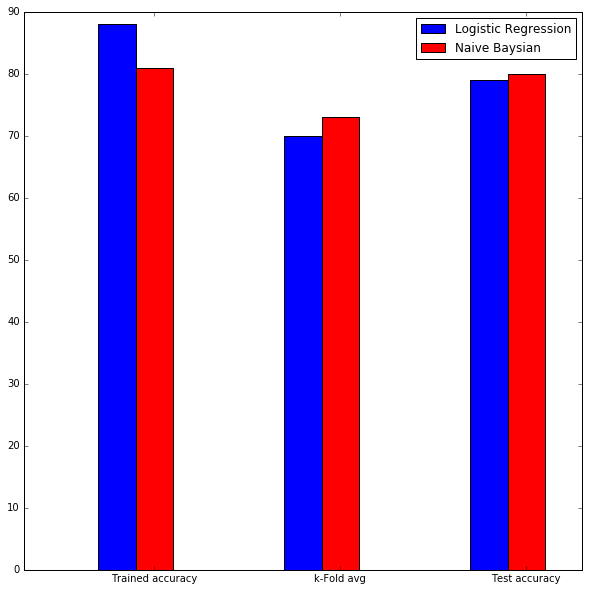

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
#import plotly.plotly as py


y = [88,70,79]
x = np.arange(len(y))
width=0.2

ax = plt.subplot()
rects1 = ax.bar(x, y,width,color='b',align='center')

y = [81,73,80]
x = np.arange(len(y))

rects2 = ax.bar(x+width, y,width,color='r',align='center')

ax.set_xticks(x+width)
ax.set_xticklabels(('Trained accuracy', 'k-Fold avg', 'Test accuracy'))

ax.legend((rects1[0], rects2[0]), ('Logistic Regression', 'Naive Baysian'))


#ax.bar(x, z,width=0.2,color='g',align='center')
#ax.bar(x+0.2, k,width=0.2,color='r',align='center')
#ax.xaxis_date()

plt.show()

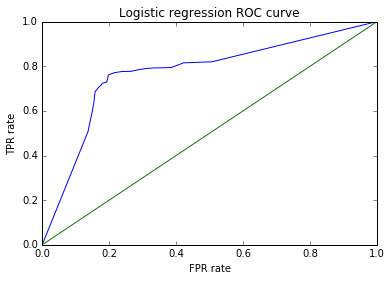

In [11]:
thresholdList = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
#thresholdList = [0.0,0.25,0.50,0.75,1.0]
tprList = []
fprList = []
tprList.append(0)
for threshold in thresholdList:
    logistic_model.clearThreshold()
    logistic_model.setThreshold(threshold)
    prediction_and_labels_logistic_roc = test_hashed.map(lambda point: (float(logistic_model.predict(point.features)), (float(point.label))))
    tps = prediction_and_labels_logistic_roc.filter(findTruePositives)
    fps = prediction_and_labels_logistic_roc.filter(findFalsePositives)
    fns = prediction_and_labels_logistic_roc.filter(findFalseNegatives)
    tns = prediction_and_labels_logistic_roc.filter(findTrueNegatives)
    if tps.count()+fns.count() == 0:
        tpr = 1
    else:
        tpr = tps.count()/(tps.count()+fns.count())
    if fps.count()+tns.count() == 0:
        fpr = 0
    else:
        fpr = fps.count()/(fps.count()+tns.count())
    tprList.append(tpr)
    fprList.append(fpr)
fprList.append(1)
#print(tprList)
#print(fprList)
tprList.sort()
fprList.sort()
%matplotlib inline
import matplotlib.pyplot as plt
#import numpy as np
#from pylab import rcParams
#rcParams['figure.figsize'] = 5, 5

plt.plot(fprList,tprList)
plt.plot([0.0,1],[0.0,1])
plt.ylabel("TPR rate")
plt.xlabel("FPR rate")
plt.title("Logistic regression ROC curve")
#plt.axis([0, 0.5, 0.5, 1])
plt.show()